In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/dataset.zip'
extract_path = '/content/drive/MyDrive/dataset'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Found 28 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step


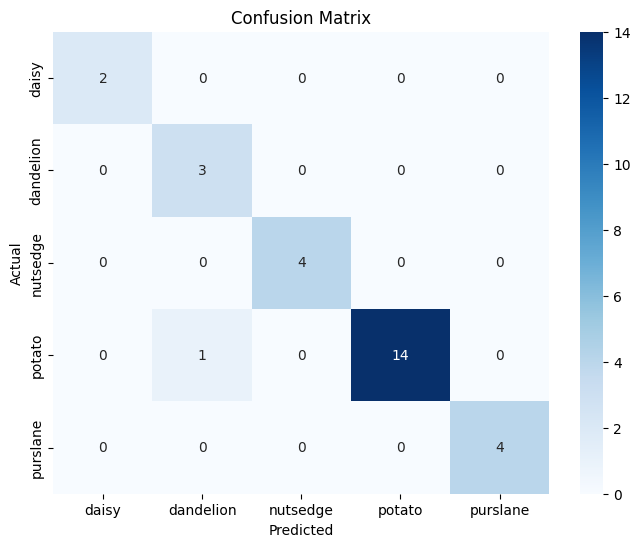

              precision    recall  f1-score   support

       daisy       1.00      1.00      1.00         2
   dandelion       0.75      1.00      0.86         3
    nutsedge       1.00      1.00      1.00         4
      potato       1.00      0.93      0.97        15
    purslane       1.00      1.00      1.00         4

    accuracy                           0.96        28
   macro avg       0.95      0.99      0.96        28
weighted avg       0.97      0.96      0.97        28



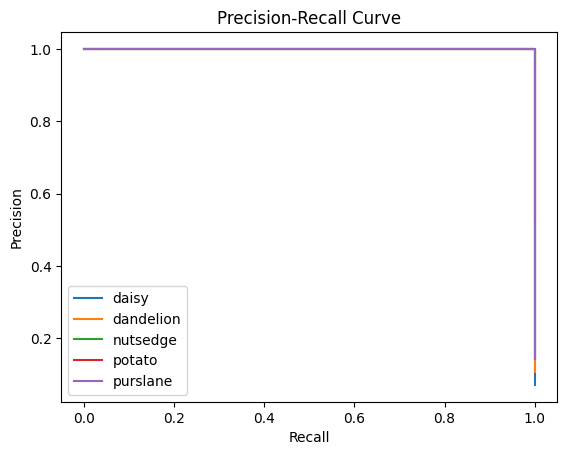

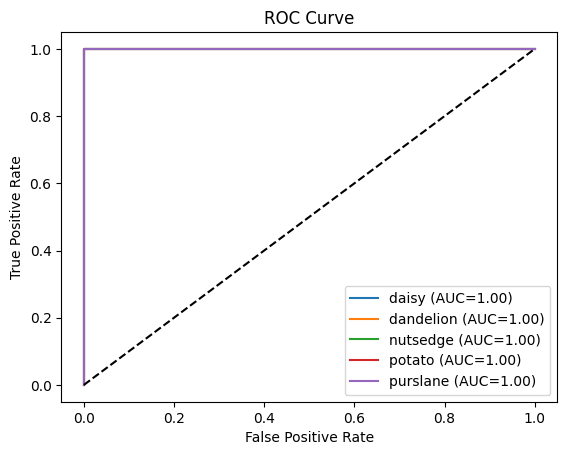

AP per class: {'daisy': np.float64(1.0), 'dandelion': np.float64(1.0), 'nutsedge': np.float64(1.0), 'potato': np.float64(1.0), 'purslane': np.float64(1.0)}
Mean Average Precision (mAP): 1.0


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve,
    roc_auc_score, average_precision_score
)
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Пути к модели и тестовым данным
MODEL_PATH = '/content/drive/MyDrive/weed_model_efficientnet.keras'
TEST_DIR = '/content/drive/MyDrive/dataset/dataset/test'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Загрузка модели
model = load_model(MODEL_PATH)

# Подготовка тестовых данных
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Определение классов
class_names = list(test_generator.class_indices.keys())

# Получаем истинные метки
y_true = test_generator.classes
y_true_onehot = label_binarize(y_true, classes=range(len(class_names)))

# Прогнозируем вероятности
y_pred_probs = model.predict(test_generator, verbose=1)

# Преобразуем вероятности в метки классов
y_pred = np.argmax(y_pred_probs, axis=1)

# Строим confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Выводим классификационный отчет
print(classification_report(y_true, y_pred, target_names=class_names))

# Строим Precision-Recall Curve
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f'{class_name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Строим ROC Curve
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    auc = roc_auc_score(y_true_onehot[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC={auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Average Precision per class
ap_per_class = {}
for i, class_name in enumerate(class_names):
    ap = average_precision_score(y_true_onehot[:, i], y_pred_probs[:, i])
    ap_per_class[class_name] = ap
mean_ap = np.mean(list(ap_per_class.values()))
print("AP per class:", ap_per_class)
print("Mean Average Precision (mAP):", mean_ap)
